
# Supplemental Information

This notebook is intended to serve as a supplement to the manuscript "High-throughput workflows for determining adsorption energies on solid surfaces."  It outlines basic use of the code and workflow software that has been developed for processing surface slabs and placing adsorbates according to symmetrically distinct sites on surface facets.

## Example 1: AdsorbateSiteFinder (pymatgen)

An example using the the AdsorbateSiteFinder class in pymatgen is shown below.  We begin with an import statement for the necessay modules.  To use the MP RESTful interface, you must provide your own API key either in the MPRester call i.e. ```mpr=MPRester("YOUR_API_KEY")``` or provide in in your .pmgrc.yaml configuration file.  API keys can be accessed at materialsproject.org under your "Dashboard."

In [ ]:
# Uncomment the subsequent lines in this cell to install dependencies for Google Colab.
# !pip install pymatgen==2022.7.19 atomate

In [ ]:
# Import statements
from matplotlib import pyplot as plt
from pymatgen.analysis.adsorption import *
from pymatgen.core import Lattice, Molecule, Structure
from pymatgen.core.surface import generate_all_slabs
from pymatgen.ext.matproj import MPRester
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer

%matplotlib inline
# Note that you must provide your own API Key, which can
# be accessed via the Dashboard at materialsproject.org
mpr = MPRester()

We create a simple fcc structure, generate it's distinct slabs, and select the slab with a miller index of (1, 1, 1).

In [ ]:
fcc_ni = Structure.from_spacegroup("Fm-3m", Lattice.cubic(3.5), ["Ni"], [[0, 0, 0]])
slabs = generate_all_slabs(fcc_ni, max_index=1, min_slab_size=8.0, min_vacuum_size=10.0)
ni_111 = [slab for slab in slabs if slab.miller_index == (1, 1, 1)][0]

We make an instance of the AdsorbateSiteFinder and use it to find the relevant adsorption sites.

In [ ]:
asf_ni_111 = AdsorbateSiteFinder(ni_111)
ads_sites = asf_ni_111.find_adsorption_sites()
print(ads_sites)
assert len(ads_sites) == 4

{'ontop': [array([1.23743687, 0.71443451, 9.0725408 ])], 'bridge': [array([-0.61871843,  1.78608627,  9.0725408 ])], 'hollow': [array([4.27067681e-16, 7.39702921e-16, 9.07254080e+00]), array([8.80455477e-16, 1.42886902e+00, 9.07254080e+00])], 'all': [array([1.23743687, 0.71443451, 9.0725408 ]), array([-0.61871843,  1.78608627,  9.0725408 ]), array([4.27067681e-16, 7.39702921e-16, 9.07254080e+00]), array([1.63125081e-15, 1.42886902e+00, 9.07254080e+00])]}


We visualize the sites using a tool from pymatgen.

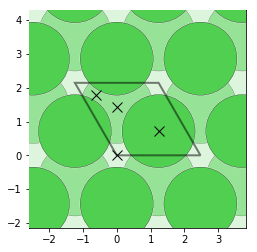

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plot_slab(ni_111, ax, adsorption_sites=True)

Use the `AdsorbateSiteFinder.generate_adsorption_structures` method to generate structures of adsorbates.

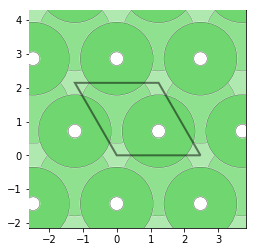

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
adsorbate = Molecule("H", [[0, 0, 0]])
ads_structs = asf_ni_111.generate_adsorption_structures(adsorbate, repeat=[1, 1, 1])
plot_slab(ads_structs[0], ax, adsorption_sites=False, decay=0.09)

## Example 2: AdsorbateSiteFinder for various surfaces

In this example, the AdsorbateSiteFinder is used to find adsorption sites on different structures and miller indices.

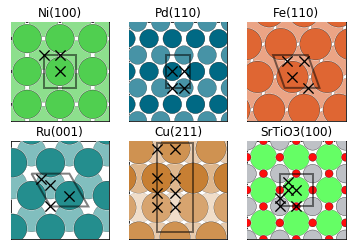

In [ ]:
fig = plt.figure()
axes = [fig.add_subplot(2, 3, i) for i in range(1, 7)]
mats = {
    "mp-23": (1, 0, 0),  # FCC Ni
    "mp-2": (1, 1, 0),  # FCC Au
    "mp-13": (1, 1, 0),  # BCC Fe
    "mp-33": (0, 0, 1),  # HCP Ru
    "mp-30": (2, 1, 1),
    "mp-5229": (1, 0, 0),
}  # Cubic SrTiO3
# "mp-2133":(0, 1, 1)} # Wurtzite ZnO

for n, (mp_id, m_index) in enumerate(mats.items()):
    struct = mpr.get_structure_by_material_id(mp_id)
    struct = SpacegroupAnalyzer(struct).get_conventional_standard_structure()
    slabs = generate_all_slabs(struct, 1, 5.0, 2.0, center_slab=True)
    slab_dict = {slab.miller_index: slab for slab in slabs}
    asf = AdsorbateSiteFinder.from_bulk_and_miller(
        struct, m_index, undercoord_threshold=0.10
    )
    plot_slab(asf.slab, axes[n])
    ads_sites = asf.find_adsorption_sites()
    sop = get_rot(asf.slab)
    ads_sites = [sop.operate(ads_site)[:2].tolist() for ads_site in ads_sites["all"]]
    axes[n].plot(
        *zip(*ads_sites),
        color="k",
        marker="x",
        markersize=10,
        mew=1,
        linestyle="",
        zorder=10000,
    )
    mi_string = "".join([str(i) for i in m_index])
    axes[n].set_title(f"{struct.composition.reduced_formula}({mi_string})")
    axes[n].set_xticks([])
    axes[n].set_yticks([])

axes[4].set_xlim(-2, 5)
axes[4].set_ylim(-2, 5)
fig.savefig("slabs.png", dpi=200)

In [ ]:
!open slabs.png

## Example 3: Generating a workflow from atomate

In this example, we demonstrate how MatMethods may be used to generate a full workflow for the determination of DFT-energies from which adsorption energies may be calculated.  Note that this requires a working instance of  [FireWorks](https://pythonhosted.org/FireWorks/index.html) and its dependency, [MongoDB](https://www.mongodb.com/).  Note that MongoDB can be installed via [Anaconda](https://anaconda.org/anaconda/mongodb).

In [ ]:
from fireworks import LaunchPad

lpad = LaunchPad()

In [ ]:
lpad.reset("", require_password=False)

2018-07-24 09:56:31,982 INFO Performing db tune-up
2018-07-24 09:56:31,995 INFO LaunchPad was RESET.


Import the necessary workflow-generating function from atomate:

In [ ]:
from atomate.vasp.workflows.base.adsorption import (
    get_wf_surface,
    get_wf_surface_all_slabs,
)

Adsorption configurations take the form of a dictionary with the miller index as a string key and a list of pymatgen Molecule instances as the values.

In [ ]:
co = Molecule("CO", [[0, 0, 0], [0, 0, 1.23]])
h = Molecule("H", [[0, 0, 0]])

Workflows are generated using the a slab a list of molecules.

In [ ]:
struct = mpr.get_structure_by_material_id("mp-23")  # fcc Ni
struct = SpacegroupAnalyzer(struct).get_conventional_standard_structure()
slabs = generate_all_slabs(struct, 1, 5.0, 2.0, center_slab=True)
slab_dict = {slab.miller_index: slab for slab in slabs}

ni_slab_111 = slab_dict[(1, 1, 1)]
wf = get_wf_surface([ni_slab_111], molecules=[co, h])
lpad.add_wf(wf)

2018-07-24 09:56:33,057 INFO Added a workflow. id_map: {-9: 1, -8: 2, -7: 3, -6: 4, -5: 5, -4: 6, -3: 7, -2: 8, -1: 9}


{-9: 1, -8: 2, -7: 3, -6: 4, -5: 5, -4: 6, -3: 7, -2: 8, -1: 9}

The workflow may be inspected as below.  Note that there are 9 optimization tasks correponding the slab, and 4 distinct adsorption configurations for each of the 2 adsorbates.  Details on running FireWorks, including [singleshot launching](https://pythonhosted.org/FireWorks/worker_tutorial.html#launch-a-rocket-on-a-worker-machine-fireworker), [queue submission](https://pythonhosted.org/FireWorks/queue_tutorial.html#), [workflow management](https://pythonhosted.org/FireWorks/defuse_tutorial.html), and more can be found in the [FireWorks documentation](https://pythonhosted.org/FireWorks/index.html).

In [ ]:
lpad.get_wf_summary_dict(1)

{'created_on': datetime.datetime(2018, 7, 24, 16, 56, 32, 939000),
 'launch_dirs': OrderedDict([('Ni27H-H1-Ni_(1, 1, 1) adsorbate optimization 3--1',
               []),
              ('Ni27H-H1-Ni_(1, 1, 1) adsorbate optimization 2--2', []),
              ('Ni27H-H1-Ni_(1, 1, 1) adsorbate optimization 1--3', []),
              ('Ni27H-H1-Ni_(1, 1, 1) adsorbate optimization 0--4', []),
              ('Ni27CO-C1 O1-Ni_(1, 1, 1) adsorbate optimization 3--5', []),
              ('Ni27CO-C1 O1-Ni_(1, 1, 1) adsorbate optimization 2--6', []),
              ('Ni27CO-C1 O1-Ni_(1, 1, 1) adsorbate optimization 1--7', []),
              ('Ni27CO-C1 O1-Ni_(1, 1, 1) adsorbate optimization 0--8', []),
              ('Ni-Ni_(1, 1, 1) slab optimization--9', [])]),
 'name': '9 surfaces wf, e.g., Ni-Ni_(1, 1, 1) slab optimization',
 'state': 'READY',
 'states': OrderedDict([('Ni27H-H1-Ni_(1, 1, 1) adsorbate optimization 3--1',
               'READY'),
              ('Ni27H-H1-Ni_(1, 1, 1) adsorbate opti

Note also that running FireWorks via atomate may require system specific tuning (e. g. for VASP parameters).  More information is available in the [atomate documentation](http://pythonhosted.org/atomate/).

## Example 4 - Screening of oxygen evolution electrocatalysts on binary oxides

This final example is intended to demonstrate how to use the MP API and the adsorption workflow to do an initial high-throughput study of oxygen evolution electrocatalysis on binary oxides of transition metals.

In [ ]:
import tqdm
from pymatgen.core.periodic_table import *
from pymatgen.core.surface import get_symmetrically_distinct_miller_indices

lpad.reset("", require_password=False)

2018-07-24 09:56:33,079 INFO Performing db tune-up
2018-07-24 09:56:33,088 INFO LaunchPad was RESET.


For oxygen evolution, a common metric for the catalytic activity of a given catalyst is the theoretical overpotential corresponding to the mechanism that proceeds through OH\*, O\*, and OOH\*.  So we can define our adsorbates:

In [ ]:
OH = Molecule("OH", [[0, 0, 0], [-0.793, 0.384, 0.422]])
O = Molecule("O", [[0, 0, 0]])
OOH = Molecule("OOH", [[0, 0, 0], [-1.067, -0.403, 0.796], [-0.696, -0.272, 1.706]])
adsorbates = [OH, O, OOH]

Then we can retrieve the structures using the MP rest interface, and write a simple for loop which creates all of the workflows corresponding to every slab and every adsorption site for each material.  The code below will take ~15 minutes.  This could be parallelized to be more efficient, but is not for simplicity in this case.

In [ ]:
elements = [Element.from_Z(i) for i in range(1, 103)]
trans_metals = [el for el in elements if el.is_transition_metal]
# tqdm adds a progress bar so we can see the progress of the for loop
for metal in tqdm.tqdm_notebook(trans_metals):
    # Get relatively stable structures with small unit cells
    data = mpr.get_data(f"{metal.symbol}-O")
    data = [datum for datum in data if datum["e_above_hull"] < 0.05]
    data = sorted(data, key=lambda x: x["nsites"])
    struct = Structure.from_str(data[0]["cif"], fmt="cif")
    # Put in conventional cell settings
    struct = SpacegroupAnalyzer(struct).get_conventional_standard_structure()
    # Get distinct miller indices for low-index facets
    wf = get_wf_surface_all_slabs(struct, adsorbates)
    lpad.add_wf(wf)
    print(f"Processed: {struct.formula}")

HBox(children=(IntProgress(value=0, max=31), HTML(value='')))

2018-07-24 09:58:07,542 INFO Added a workflow. id_map: {-1777: 1, -1776: 2, -1775: 3, -1774: 4, -1773: 5, -1772: 6, -1771: 7, -1770: 8, -1769: 9, -1768: 10, -1767: 11, -1766: 12, -1765: 13, -1764: 14, -1763: 15, -1762: 16, -1761: 17, -1760: 18, -1759: 19, -1758: 20, -1757: 21, -1756: 22, -1755: 23, -1754: 24, -1753: 25, -1752: 26, -1751: 27, -1750: 28, -1749: 29, -1748: 30, -1747: 31, -1746: 32, -1745: 33, -1744: 34, -1743: 35, -1742: 36, -1741: 37, -1740: 38, -1739: 39, -1738: 40, -1737: 41, -1736: 42, -1735: 43, -1734: 44, -1733: 45, -1732: 46, -1731: 47, -1730: 48, -1729: 49, -1728: 50, -1727: 51, -1726: 52, -1725: 53, -1724: 54, -1723: 55, -1722: 56, -1721: 57, -1720: 58, -1719: 59, -1718: 60, -1717: 61, -1716: 62, -1715: 63, -1714: 64, -1713: 65, -1712: 66, -1711: 67, -1710: 68, -1709: 69, -1708: 70, -1707: 71, -1706: 72, -1705: 73, -1704: 74, -1703: 75, -1702: 76, -1701: 77, -1700: 78, -1699: 79, -1698: 80, -1697: 81, -1696: 82, -1695: 83, -1694: 84, -1693: 85, -1692: 86, -1691: 

Processed: Sc12 O18
2018-07-24 09:58:14,652 INFO Added a workflow. id_map: {-2132: 1769, -2131: 1770, -2130: 1771, -2129: 1772, -2128: 1773, -2127: 1774, -2126: 1775, -2125: 1776, -2124: 1777, -2123: 1778, -2122: 1779, -2121: 1780, -2120: 1781, -2119: 1782, -2118: 1783, -2117: 1784, -2116: 1785, -2115: 1786, -2114: 1787, -2113: 1788, -2112: 1789, -2111: 1790, -2110: 1791, -2109: 1792, -2108: 1793, -2107: 1794, -2106: 1795, -2105: 1796, -2104: 1797, -2103: 1798, -2102: 1799, -2101: 1800, -2100: 1801, -2099: 1802, -2098: 1803, -2097: 1804, -2096: 1805, -2095: 1806, -2094: 1807, -2093: 1808, -2092: 1809, -2091: 1810, -2090: 1811, -2089: 1812, -2088: 1813, -2087: 1814, -2086: 1815, -2085: 1816, -2084: 1817, -2083: 1818, -2082: 1819, -2081: 1820, -2080: 1821, -2079: 1822, -2078: 1823, -2077: 1824, -2076: 1825, -2075: 1826, -2074: 1827, -2073: 1828, -2072: 1829, -2071: 1830, -2070: 1831, -2069: 1832, -2068: 1833, -2067: 1834, -2066: 1835, -2065: 1836, -2064: 1837, -2063: 1838, -2062: 1839, -

Processed: Cr2 O4
2018-07-24 09:58:35,696 INFO Added a workflow. id_map: {-2908: 2854, -2907: 2855, -2906: 2856, -2905: 2857, -2904: 2858, -2903: 2859, -2902: 2860, -2901: 2861, -2900: 2862, -2899: 2863, -2898: 2864, -2897: 2865, -2896: 2866, -2895: 2867, -2894: 2868, -2893: 2869, -2892: 2870, -2891: 2871, -2890: 2872, -2889: 2873, -2888: 2874, -2887: 2875, -2886: 2876, -2885: 2877, -2884: 2878, -2883: 2879, -2882: 2880, -2881: 2881, -2880: 2882, -2879: 2883, -2878: 2884, -2877: 2885, -2876: 2886, -2875: 2887, -2874: 2888, -2873: 2889, -2872: 2890, -2871: 2891, -2870: 2892, -2869: 2893, -2868: 2894, -2867: 2895, -2866: 2896, -2865: 2897, -2864: 2898, -2863: 2899}
Processed: Mn4 O4
2018-07-24 09:58:38,594 INFO Added a workflow. id_map: {-2998: 2900, -2997: 2901, -2996: 2902, -2995: 2903, -2994: 2904, -2993: 2905, -2992: 2906, -2991: 2907, -2990: 2908, -2989: 2909, -2988: 2910, -2987: 2911, -2986: 2912, -2985: 2913, -2984: 2914, -2983: 2915, -2982: 2916, -2981: 2917, -2980: 2918, -2979: 

Processed: Cu4 O4
2018-07-24 09:58:56,924 INFO Added a workflow. id_map: {-3682: 3603, -3681: 3604, -3680: 3605, -3679: 3606, -3678: 3607, -3677: 3608, -3676: 3609, -3675: 3610, -3674: 3611, -3673: 3612, -3672: 3613, -3671: 3614, -3670: 3615, -3669: 3616, -3668: 3617, -3667: 3618, -3666: 3619, -3665: 3620, -3664: 3621, -3663: 3622, -3662: 3623, -3661: 3624, -3660: 3625, -3659: 3626, -3658: 3627, -3657: 3628, -3656: 3629, -3655: 3630, -3654: 3631, -3653: 3632, -3652: 3633, -3651: 3634, -3650: 3635, -3649: 3636, -3648: 3637, -3647: 3638, -3646: 3639, -3645: 3640, -3644: 3641, -3643: 3642, -3642: 3643, -3641: 3644, -3640: 3645, -3639: 3646, -3638: 3647, -3637: 3648, -3636: 3649, -3635: 3650, -3634: 3651, -3633: 3652, -3632: 3653, -3631: 3654, -3630: 3655, -3629: 3656, -3628: 3657, -3627: 3658, -3626: 3659, -3625: 3660, -3624: 3661, -3623: 3662, -3622: 3663, -3621: 3664, -3620: 3665, -3619: 3666, -3618: 3667, -3617: 3668, -3616: 3669, -3615: 3670, -3614: 3671, -3613: 3672, -3612: 3673}
Pro

Processed: Y12 O18
2018-07-24 10:04:04,452 INFO Added a workflow. id_map: {-9573: 9038, -9572: 9039, -9571: 9040, -9570: 9041, -9569: 9042, -9568: 9043, -9567: 9044, -9566: 9045, -9565: 9046, -9564: 9047, -9563: 9048, -9562: 9049, -9561: 9050, -9560: 9051, -9559: 9052, -9558: 9053, -9557: 9054, -9556: 9055, -9555: 9056, -9554: 9057, -9553: 9058, -9552: 9059, -9551: 9060, -9550: 9061, -9549: 9062, -9548: 9063, -9547: 9064, -9546: 9065, -9545: 9066, -9544: 9067, -9543: 9068, -9542: 9069, -9541: 9070, -9540: 9071, -9539: 9072, -9538: 9073, -9537: 9074, -9536: 9075, -9535: 9076, -9534: 9077, -9533: 9078, -9532: 9079, -9531: 9080, -9530: 9081, -9529: 9082, -9528: 9083, -9527: 9084, -9526: 9085, -9525: 9086, -9524: 9087, -9523: 9088, -9522: 9089, -9521: 9090, -9520: 9091, -9519: 9092, -9518: 9093, -9517: 9094, -9516: 9095, -9515: 9096, -9514: 9097, -9513: 9098, -9512: 9099, -9511: 9100, -9510: 9101, -9509: 9102, -9508: 9103, -9507: 9104, -9506: 9105, -9505: 9106, -9504: 9107, -9503: 9108, -9

Processed: Mo4 O8
2018-07-24 10:06:39,853 INFO Added a workflow. id_map: {-14658: 11298, -14657: 11299, -14656: 11300, -14655: 11301, -14654: 11302, -14653: 11303, -14652: 11304, -14651: 11305, -14650: 11306, -14649: 11307, -14648: 11308, -14647: 11309, -14646: 11310, -14645: 11311, -14644: 11312, -14643: 11313, -14642: 11314, -14641: 11315, -14640: 11316, -14639: 11317, -14638: 11318, -14637: 11319, -14636: 11320, -14635: 11321, -14634: 11322, -14633: 11323, -14632: 11324, -14631: 11325, -14630: 11326, -14629: 11327, -14628: 11328, -14627: 11329, -14626: 11330, -14625: 11331, -14624: 11332, -14623: 11333, -14622: 11334, -14621: 11335, -14620: 11336, -14619: 11337, -14618: 11338, -14617: 11339, -14616: 11340, -14615: 11341, -14614: 11342, -14613: 11343, -14612: 11344, -14611: 11345, -14610: 11346, -14609: 11347, -14608: 11348, -14607: 11349, -14606: 11350, -14605: 11351, -14604: 11352, -14603: 11353, -14602: 11354, -14601: 11355, -14600: 11356, -14599: 11357, -14598: 11358, -14597: 113

Processed: Tc4 O8
2018-07-24 10:06:49,037 INFO Added a workflow. id_map: {-14992: 14650, -14991: 14651, -14990: 14652, -14989: 14653, -14988: 14654, -14987: 14655, -14986: 14656, -14985: 14657, -14984: 14658, -14983: 14659, -14982: 14660, -14981: 14661, -14980: 14662, -14979: 14663, -14978: 14664, -14977: 14665, -14976: 14666, -14975: 14667, -14974: 14668, -14973: 14669, -14972: 14670, -14971: 14671, -14970: 14672, -14969: 14673, -14968: 14674, -14967: 14675, -14966: 14676, -14965: 14677, -14964: 14678, -14963: 14679, -14962: 14680, -14961: 14681, -14960: 14682, -14959: 14683, -14958: 14684, -14957: 14685, -14956: 14686, -14955: 14687, -14954: 14688, -14953: 14689, -14952: 14690, -14951: 14691, -14950: 14692, -14949: 14693, -14948: 14694, -14947: 14695, -14946: 14696, -14945: 14697, -14944: 14698, -14943: 14699, -14942: 14700, -14941: 14701, -14940: 14702, -14939: 14703, -14938: 14704, -14937: 14705, -14936: 14706, -14935: 14707, -14934: 14708, -14933: 14709, -14932: 14710, -14931: 147

Processed: Rh2 O4
2018-07-24 10:07:00,584 INFO Added a workflow. id_map: {-15462: 15297, -15461: 15298, -15460: 15299, -15459: 15300, -15458: 15301, -15457: 15302, -15456: 15303, -15455: 15304, -15454: 15305, -15453: 15306, -15452: 15307, -15451: 15308, -15450: 15309, -15449: 15310, -15448: 15311, -15447: 15312, -15446: 15313, -15445: 15314, -15444: 15315, -15443: 15316, -15442: 15317, -15441: 15318, -15440: 15319, -15439: 15320, -15438: 15321, -15437: 15322, -15436: 15323, -15435: 15324, -15434: 15325, -15433: 15326, -15432: 15327, -15431: 15328, -15430: 15329, -15429: 15330, -15428: 15331, -15427: 15332, -15426: 15333, -15425: 15334, -15424: 15335, -15423: 15336, -15422: 15337, -15421: 15338, -15420: 15339, -15419: 15340, -15418: 15341, -15417: 15342, -15416: 15343, -15415: 15344, -15414: 15345, -15413: 15346, -15412: 15347, -15411: 15348, -15410: 15349, -15409: 15350, -15408: 15351, -15407: 15352, -15406: 15353, -15405: 15354, -15404: 15355, -15403: 15356, -15402: 15357, -15401: 153

Processed: La2 O3
2018-07-24 10:07:25,044 INFO Added a workflow. id_map: {-16497: 16263, -16496: 16264, -16495: 16265, -16494: 16266, -16493: 16267, -16492: 16268, -16491: 16269, -16490: 16270, -16489: 16271, -16488: 16272, -16487: 16273, -16486: 16274, -16485: 16275, -16484: 16276, -16483: 16277, -16482: 16278, -16481: 16279, -16480: 16280, -16479: 16281, -16478: 16282, -16477: 16283, -16476: 16284, -16475: 16285, -16474: 16286, -16473: 16287, -16472: 16288, -16471: 16289, -16470: 16290, -16469: 16291, -16468: 16292, -16467: 16293, -16466: 16294, -16465: 16295, -16464: 16296, -16463: 16297, -16462: 16298, -16461: 16299, -16460: 16300, -16459: 16301, -16458: 16302, -16457: 16303, -16456: 16304, -16455: 16305, -16454: 16306, -16453: 16307, -16452: 16308, -16451: 16309, -16450: 16310, -16449: 16311, -16448: 16312, -16447: 16313, -16446: 16314, -16445: 16315, -16444: 16316, -16443: 16317, -16442: 16318, -16441: 16319, -16440: 16320, -16439: 16321, -16438: 16322, -16437: 16323, -16436: 163

Processed: Ta4 O10
2018-07-24 10:17:32,149 INFO Added a workflow. id_map: {-28531: 19180, -28530: 19181, -28529: 19182, -28528: 19183, -28527: 19184, -28526: 19185, -28525: 19186, -28524: 19187, -28523: 19188, -28522: 19189, -28521: 19190, -28520: 19191, -28519: 19192, -28518: 19193, -28517: 19194, -28516: 19195, -28515: 19196, -28514: 19197, -28513: 19198, -28512: 19199, -28511: 19200, -28510: 19201, -28509: 19202, -28508: 19203, -28507: 19204, -28506: 19205, -28505: 19206, -28504: 19207, -28503: 19208, -28502: 19209, -28501: 19210, -28500: 19211, -28499: 19212, -28498: 19213, -28497: 19214, -28496: 19215, -28495: 19216, -28494: 19217, -28493: 19218, -28492: 19219, -28491: 19220, -28490: 19221, -28489: 19222, -28488: 19223, -28487: 19224, -28486: 19225, -28485: 19226, -28484: 19227, -28483: 19228, -28482: 19229, -28481: 19230, -28480: 19231, -28479: 19232, -28478: 19233, -28477: 19234, -28476: 19235, -28475: 19236, -28474: 19237, -28473: 19238, -28472: 19239, -28471: 19240, -28470: 19

Processed: W8 O24
2018-07-24 10:17:54,623 INFO Added a workflow. id_map: {-29005: 28523, -29004: 28524, -29003: 28525, -29002: 28526, -29001: 28527, -29000: 28528, -28999: 28529, -28998: 28530, -28997: 28531, -28996: 28532, -28995: 28533, -28994: 28534, -28993: 28535, -28992: 28536, -28991: 28537, -28990: 28538, -28989: 28539, -28988: 28540, -28987: 28541, -28986: 28542, -28985: 28543, -28984: 28544, -28983: 28545, -28982: 28546, -28981: 28547, -28980: 28548, -28979: 28549, -28978: 28550, -28977: 28551, -28976: 28552, -28975: 28553, -28974: 28554, -28973: 28555, -28972: 28556, -28971: 28557, -28970: 28558, -28969: 28559, -28968: 28560, -28967: 28561, -28966: 28562, -28965: 28563, -28964: 28564, -28963: 28565, -28962: 28566, -28961: 28567, -28960: 28568, -28959: 28569, -28958: 28570, -28957: 28571, -28956: 28572, -28955: 28573, -28954: 28574, -28953: 28575, -28952: 28576, -28951: 28577, -28950: 28578, -28949: 28579, -28948: 28580, -28947: 28581, -28946: 28582, -28945: 28583, -28944: 285

Processed: Os2 O8
2018-07-24 10:18:37,697 INFO Added a workflow. id_map: {-30827: 30485, -30826: 30486, -30825: 30487, -30824: 30488, -30823: 30489, -30822: 30490, -30821: 30491, -30820: 30492, -30819: 30493, -30818: 30494, -30817: 30495, -30816: 30496, -30815: 30497, -30814: 30498, -30813: 30499, -30812: 30500, -30811: 30501, -30810: 30502, -30809: 30503, -30808: 30504, -30807: 30505, -30806: 30506, -30805: 30507, -30804: 30508, -30803: 30509, -30802: 30510, -30801: 30511, -30800: 30512, -30799: 30513, -30798: 30514, -30797: 30515, -30796: 30516, -30795: 30517, -30794: 30518, -30793: 30519, -30792: 30520, -30791: 30521, -30790: 30522, -30789: 30523, -30788: 30524, -30787: 30525, -30786: 30526, -30785: 30527, -30784: 30528, -30783: 30529, -30782: 30530, -30781: 30531, -30780: 30532, -30779: 30533, -30778: 30534, -30777: 30535, -30776: 30536, -30775: 30537, -30774: 30538, -30773: 30539, -30772: 30540, -30771: 30541, -30770: 30542, -30769: 30543, -30768: 30544, -30767: 30545, -30766: 305

Processed: Pt1 O2
2018-07-24 10:19:59,990 INFO Added a workflow. id_map: {-33077: 31042, -33076: 31043, -33075: 31044, -33074: 31045, -33073: 31046, -33072: 31047, -33071: 31048, -33070: 31049, -33069: 31050, -33068: 31051, -33067: 31052, -33066: 31053, -33065: 31054, -33064: 31055, -33063: 31056, -33062: 31057, -33061: 31058, -33060: 31059, -33059: 31060, -33058: 31061, -33057: 31062, -33056: 31063, -33055: 31064, -33054: 31065, -33053: 31066, -33052: 31067, -33051: 31068, -33050: 31069, -33049: 31070, -33048: 31071, -33047: 31072, -33046: 31073, -33045: 31074, -33044: 31075, -33043: 31076, -33042: 31077, -33041: 31078, -33040: 31079, -33039: 31080, -33038: 31081, -33037: 31082, -33036: 31083, -33035: 31084, -33034: 31085, -33033: 31086, -33032: 31087, -33031: 31088, -33030: 31089, -33029: 31090, -33028: 31091, -33027: 31092, -33026: 31093, -33025: 31094, -33024: 31095, -33023: 31096, -33022: 31097, -33021: 31098, -33020: 31099, -33019: 31100, -33018: 31101, -33017: 31102, -33016: 311

Processed: Au16 O24
2018-07-24 10:20:21,814 INFO Added a workflow. id_map: {-34031: 33069, -34030: 33070, -34029: 33071, -34028: 33072, -34027: 33073, -34026: 33074, -34025: 33075, -34024: 33076, -34023: 33077, -34022: 33078, -34021: 33079, -34020: 33080, -34019: 33081, -34018: 33082, -34017: 33083, -34016: 33084, -34015: 33085, -34014: 33086, -34013: 33087, -34012: 33088, -34011: 33089, -34010: 33090, -34009: 33091, -34008: 33092, -34007: 33093, -34006: 33094, -34005: 33095, -34004: 33096, -34003: 33097, -34002: 33098, -34001: 33099, -34000: 33100, -33999: 33101, -33998: 33102, -33997: 33103, -33996: 33104, -33995: 33105, -33994: 33106, -33993: 33107, -33992: 33108, -33991: 33109, -33990: 33110, -33989: 33111, -33988: 33112, -33987: 33113, -33986: 33114, -33985: 33115, -33984: 33116, -33983: 33117, -33982: 33118, -33981: 33119, -33980: 33120, -33979: 33121, -33978: 33122, -33977: 33123, -33976: 33124, -33975: 33125, -33974: 33126, -33973: 33127, -33972: 33128, -33971: 33129, -33970: 3

Processed: Hg3 O3
2018-07-24 10:20:30,175 INFO Added a workflow. id_map: {-34455: 34023, -34454: 34024, -34453: 34025, -34452: 34026, -34451: 34027, -34450: 34028, -34449: 34029, -34448: 34030, -34447: 34031, -34446: 34032, -34445: 34033, -34444: 34034, -34443: 34035, -34442: 34036, -34441: 34037, -34440: 34038, -34439: 34039, -34438: 34040, -34437: 34041, -34436: 34042, -34435: 34043, -34434: 34044, -34433: 34045, -34432: 34046, -34431: 34047, -34430: 34048, -34429: 34049, -34428: 34050, -34427: 34051, -34426: 34052, -34425: 34053, -34424: 34054, -34423: 34055, -34422: 34056, -34421: 34057, -34420: 34058, -34419: 34059, -34418: 34060, -34417: 34061, -34416: 34062, -34415: 34063, -34414: 34064, -34413: 34065, -34412: 34066, -34411: 34067, -34410: 34068, -34409: 34069, -34408: 34070, -34407: 34071, -34406: 34072, -34405: 34073, -34404: 34074, -34403: 34075, -34402: 34076, -34401: 34077, -34400: 34078, -34399: 34079, -34398: 34080, -34397: 34081, -34396: 34082, -34395: 34083, -34394: 340

Ultimately, running this code produces workflows that contain many (tens of thousands) of calculations, all of which can be managed using FireWorks and queued on supercomputing resources.  Limitations on those resources might necessitate a more selective approach towards choosing surface facets or representative materials.  Nevertheless, this approach represents a way to provide for a complete and structurally accurate way of screening materials for adsorption properties than can be managed using fireworks.